In [113]:
import pandas as pd

import numpy as np
pd.set_option('display.max_columns', None)

import rdkit.Chem as Chem
import datamol as dm
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [114]:
from sklearn.preprocessing import StandardScaler 
def do_scaling(scaler=StandardScaler(), xtrain=None, xtest=None):
    """
    Usage: do_scaling(scaler=MinMaxScaler(), xtrain=xtrain, xtest=test) 
    xtrain and xtest are pd.Dataframes
    Caution: Do test_train_split before scaling
    Return: return scaled non-None xtrain and xtest
    """
    st = scaler

    if xtrain is not None:
        col=xtrain.columns.values.tolist()
        xtrain=st.fit_transform(xtrain)  
        xtrain=pd.DataFrame(xtrain,columns=col)

        if xtest is not None:
            
            xtest=st.transform(xtest)
            xtest=pd.DataFrame(xtest,columns=col)
            print("returning scaled train and test data")
            return xtrain,xtest
        else:
            print("test data is not provided, returning only scaled train data")
            return xtrain
    else:
        print("Give train data, returning None")
        return xtrain,xtest

In [115]:
def substruct_in_smi(mol_smi_str,pat_smi_str):
    """
    This function will return True if the substructure (pattern) is present in the SMILES string.
    Input: smi_str = A SMILES string;   sub_str = Pattern 
    Output: True (substruture found in the smi); False (substruture not found in the smi)
    """   
    mol = Chem.MolFromSmiles(mol_smi_str)
    pat = Chem.MolFromSmiles(pat_smi_str) 

    return mol.HasSubstructMatch(pat)

In [116]:
def All_Mordred_descriptors(data,ignore_3D=True):
    """
    Function will return all mordred features
    """
    from mordred import Calculator, descriptors
    from rdkit.Chem import AllChem
    calc = Calculator(descriptors, ignore_3D=ignore_3D)
    # mols = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in data]
    mols = []
    for smi in data:
        m=Chem.MolFromSmiles(smi)
        if not ignore_3D:
            m=Chem.AddHs(m) # for 3D descriptors
            AllChem.EmbedMolecule(m) # for 3D descriptors
            AllChem.UFFOptimizeMolecule(m)  # for 3D descriptors
        mols.append(m)
    # pandas df
    df = calc.pandas(mols)
    return df

In [117]:
def data_cleaning(df):
    # check columns with nan
    columns_with_nan=df.columns[df.isna().any()]
    print(f"Removing {len(columns_with_nan)} columns with nan, if any")
    print(f"Before: df.shape={df.shape}")
    df = df.dropna(axis='columns')
    # df = df.drop(columns=columns_with_nan)
    print(f"After: df.shape={df.shape} \n")    
    

    # Remove duplicates
    print(f"removing {sum(df.columns.duplicated())} duplicate columns, if any")
    print(f"Before: df.shape={df.shape}")
    df=df.loc[:,~df.columns.duplicated()].copy()
    print(f"After: df.shape={df.shape} \n")
    
    
    # Remove columns with a unique value
    print(f"removing {sum(df.nunique()<2)} columns values with a unique value")
    print(f"Before: df.shape={df.shape}")
    df=df.loc[:,df.nunique()>1]
    print(f"After: df.shape={df.shape} \n")
    
    print("returning a clean df")
    return df


In [118]:
# # only limited descriptors
# from mordred import Calculator,descriptors
# from mordred.descriptors import HydrogenBond, RotatableBond, Weight, Aromatic, RingCount, AtomCount

# mols=[Chem.MolFromSmiles(smi) for smi in df_mordred["SMILES"]]
# df_mordred_limited = Calculator([	HydrogenBond, RotatableBond, Weight, Aromatic, RingCount, AtomCount],ignore_3D=True).pandas(mols=mols)
# df_mordred_limited.head()

In [119]:
def RDkit_descriptors(smiles):
    """
    Function will return all 208 RDKit descriptors
    smiles is a pandas series or a list of smiles
    """
    from rdkit.ML.Descriptors import MoleculeDescriptors
    from rdkit.Chem import Descriptors
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 208 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

In [120]:
# df22=pd.read_csv(r"C:\Users\jaina\Box\Eli-Garvit-BzNSN\Manuscript_Figure_Analysis\Data\00_DFT_1594_clean.csv",usecols=["smiles","complexity","DelE_red(V)"])
# df22=pd.read_csv(r"C:\Users\jaina\Box\Eli-Garvit-BzNSN\Manuscript_Figure_Analysis\Data\production\BTZ_smi_complexity_ered_ag_random_1500.csv")
# df22_rdkit=pd.read_csv(r"C:\Users\jaina\Box\Eli-Garvit-BzNSN\Manuscript_Figure_Analysis\Data\00_DFT_1594_clean_features.csv")

In [121]:
df22=pd.read_csv(r"C:\Users\jaina\Box\Eli-Garvit-BzNSN\Manuscript_Figure_Analysis\Data\production\BTZ_smi_Ered_MPP_2763.csv",usecols=['SMILES', 'MPP(A)', 'Ered_ag'])
df22

,SMILES,MPP(A),Ered_ag
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,-2.58
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,-2.58
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.279319,-2.61
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.039480,-2.63
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.296932,-2.65
...,...,...,...
2758,CCCN1CCN(CCOCC)c2cc3nsnc3c(C)c21,1.129065,-2.60
2759,CCC(C)OCCN1CN(C)c2cc3nsnc3cc21,1.075593,-2.74
2760,CCN(C)c1c2c(cc3nsnc13)N(CC)CN2CC,1.195435,-2.78
2761,CCCCOCCN1CN(C)c2cc3nsnc3cc21,0.722666,-2.72


In [122]:
df22_mpp=pd.read_csv(r"C:\Users\jaina\Box\Machine_Learning_Chemistry\Data\filename_smi_multifnMPP_all_2763.csv",usecols=["SMILES","Ered_ag","MPP_heavy(Angstrom)","MPP_all(Angstrom)"])
df22_mpp

,Ered_ag,SMILES,MPP_all(Angstrom),MPP_heavy(Angstrom)
0,-2.58,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,0.477902
1,-2.58,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,0.463461
2,-2.61,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.279319,0.873632
3,-2.63,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.039480,0.676225
4,-2.65,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.296932,0.896958
...,...,...,...,...
2758,-2.60,CCCN1CCN(CCOCC)c2cc3nsnc3c(C)c21,1.129065,0.784149
2759,-2.74,CCC(C)OCCN1CN(C)c2cc3nsnc3cc21,1.075593,0.678972
2760,-2.78,CCN(C)c1c2c(cc3nsnc13)N(CC)CN2CC,1.195435,0.737310
2761,-2.72,CCCCOCCN1CN(C)c2cc3nsnc3cc21,0.722666,0.318269


In [123]:
in_mpp=[]
in_smi=[]
for smi in df22.SMILES.to_list():
    if smi in df22_mpp.SMILES.to_list():
        in_smi.append(df22.SMILES.to_list().index(smi))
        in_mpp.append(df22_mpp.SMILES.to_list().index(smi))
    else:
        print(smi)
print(len(in_mpp),len(in_smi))

2763 2763


In [124]:
df22_mpp_clean=df22_mpp.loc[in_mpp]
df22_mpp_clean.index=np.arange(len(df22_mpp_clean))

In [125]:
df22_mpp_clean

,Ered_ag,SMILES,MPP_all(Angstrom),MPP_heavy(Angstrom)
0,-2.58,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,0.477902
1,-2.58,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,0.463461
2,-2.61,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.279319,0.873632
3,-2.63,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.039480,0.676225
4,-2.65,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.296932,0.896958
...,...,...,...,...
2758,-2.60,CCCN1CCN(CCOCC)c2cc3nsnc3c(C)c21,1.129065,0.784149
2759,-2.74,CCC(C)OCCN1CN(C)c2cc3nsnc3cc21,1.075593,0.678972
2760,-2.78,CCN(C)c1c2c(cc3nsnc13)N(CC)CN2CC,1.195435,0.737310
2761,-2.72,CCCCOCCN1CN(C)c2cc3nsnc3cc21,0.722666,0.318269


In [126]:
df22

,SMILES,MPP(A),Ered_ag
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,-2.58
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,-2.58
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.279319,-2.61
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.039480,-2.63
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.296932,-2.65
...,...,...,...
2758,CCCN1CCN(CCOCC)c2cc3nsnc3c(C)c21,1.129065,-2.60
2759,CCC(C)OCCN1CN(C)c2cc3nsnc3cc21,1.075593,-2.74
2760,CCN(C)c1c2c(cc3nsnc13)N(CC)CN2CC,1.195435,-2.78
2761,CCCCOCCN1CN(C)c2cc3nsnc3cc21,0.722666,-2.72


In [127]:
df22_mpp_clean.insert(1,"smiles1",df22.SMILES.to_list())
# df22_mpp_clean.insert(2,"complexity",df22.complexity.to_list())
df22_mpp_clean

,Ered_ag,smiles1,SMILES,MPP_all(Angstrom),MPP_heavy(Angstrom)
0,-2.58,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,0.477902
1,-2.58,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,0.463461
2,-2.61,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.279319,0.873632
3,-2.63,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.039480,0.676225
4,-2.65,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.296932,0.896958
...,...,...,...,...,...
2758,-2.60,CCCN1CCN(CCOCC)c2cc3nsnc3c(C)c21,CCCN1CCN(CCOCC)c2cc3nsnc3c(C)c21,1.129065,0.784149
2759,-2.74,CCC(C)OCCN1CN(C)c2cc3nsnc3cc21,CCC(C)OCCN1CN(C)c2cc3nsnc3cc21,1.075593,0.678972
2760,-2.78,CCN(C)c1c2c(cc3nsnc13)N(CC)CN2CC,CCN(C)c1c2c(cc3nsnc13)N(CC)CN2CC,1.195435,0.737310
2761,-2.72,CCCCOCCN1CN(C)c2cc3nsnc3cc21,CCCCOCCN1CN(C)c2cc3nsnc3cc21,0.722666,0.318269


In [128]:
all(df22_mpp_clean.smiles1==df22_mpp_clean.SMILES)

True

In [129]:
df22=df22_mpp_clean.drop(columns="smiles1")
del df22_mpp_clean
print(df22.shape)
df22.head()

(2763, 4)


,Ered_ag,SMILES,MPP_all(Angstrom),MPP_heavy(Angstrom)
0,-2.58,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,0.477902
1,-2.58,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,0.463461
2,-2.61,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.279319,0.873632
3,-2.63,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.039480,0.676225
4,-2.65,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.296932,0.896958


In [130]:
# call function
Mol_descriptors,desc_names = RDkit_descriptors(smiles=df22.SMILES)
df22_rdkit = pd.DataFrame(Mol_descriptors,columns=desc_names)
df22_rdkit
# df22_rdkit=

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.673164,-4.313692,8.673164,0.278641,0.861773,291.424,270.256,291.151767,108,0,0.109421,-0.371076,0.371076,0.109421,1.550000,2.500000,3.300000,1.460045e-15,-0.246537,-2.572833e-17,-2.722027,-1.166959e-16,-2.828997,4.401419e-16,-1.048429,2.676061,1319.710561,32.317473,30.644316,10.460813,17.869915,15.574823,5.805120,3.612095,4.140543,2.417668,2.946116,1.611669,2.125660,-1.40,1.083990e+08,3.329290,5.179478,2.226066,153.172494,14.699729,11.033401,0.000000,0.0,0.0,0.0,0.0,0.0,8.74708,0.0,0.000000,26.845965,57.717337,32.698270,28.785930,34.136361,0.0,13.64699,0.0,6.851892,56.714739,11.605870,0.0,0.000000,9.799819,11.374773,0.000000,11.728187,60.561909,0.000000,6.851892,34.349381,6.042419,0.000000,11.033401,0.0,35.50,97.580675,0.0,0.0,4.899910,11.728187,0.0,0.0,0.0,0.0,8.747080,28.785930,177.855130,0.330538,-1.645123,0.000000,-5.035603,0.000000,-1.044342,0.000000,-31.627267,0.000000,0.571429,20,0,5,0,1,1,1,1,2,6,0,6,7,0,0,0,3,1.81752,86.1890,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,0,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8.626172,-4.129610,8.626172,0.326009,0.864637,292.408,272.248,292.135782,108,0,0.109421,-0.382853,0.382853,0.109421,1.550000,2.500000,3.350000,4.819916e-15,-0.248509,-2.855418e-17,-2.715352,-3.770785e-17,-2.810480,5.445269e-16,-1.039085,2.689828,1309.444040,31.447229,29.605351,10.421848,17.460996,15.062251,5.792548,3.480809,4.009257,2.464343,2.992790,1.663987,2.177978,-1.40,7.818057e+07,3.495314,5.53535

In [131]:
df22_rdkit.insert(0,"MPP_all(A)",df22["MPP_all(Angstrom)"].to_list())
df22_rdkit.insert(1,"MPP_heavy(A)",df22["MPP_heavy(Angstrom)"].to_list())
df22_rdkit.insert(0,"smiles",df22.SMILES)
df22_rdkit

,smiles,MPP_all(A),MPP_heavy(A),MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,0.477902,8.673164,-4.313692,8.673164,0.278641,0.861773,291.424,270.256,291.151767,108,0,0.109421,-0.371076,0.371076,0.109421,1.550000,2.500000,3.300000,1.460045e-15,-0.246537,-2.572833e-17,-2.722027,-1.166959e-16,-2.828997,4.401419e-16,-1.048429,2.676061,1319.710561,32.317473,30.644316,10.460813,17.869915,15.574823,5.805120,3.612095,4.140543,2.417668,2.946116,1.611669,2.125660,-1.40,1.083990e+08,3.329290,5.179478,2.226066,153.172494,14.699729,11.033401,0.000000,0.0,0.0,0.0,0.0,0.0,8.74708,0.0,0.000000,26.845965,57.717337,32.698270,28.785930,34.136361,0.0,13.64699,0.0,6.851892,56.714739,11.605870,0.0,0.000000,9.799819,11.374773,0.000000,11.728187,60.561909,0.000000,6.851892,34.349381,6.042419,0.000000,11.033401,0.0,35.50,97.580675,0.0,0.0,4.899910,11.728187,0.0,0.0,0.0,0.0,8.747080,28.785930,177.855130,0.330538,-1.645123,0.000000,-5.035603,0.000000,-1.044342,0.000000,-31.627267,0.000000,0.571429,20,0,5,0,1,1,1,1,2,6,0,6,7,0,0,0,3,1.81752,86.1890,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,0,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,0.463461,8.626172,-4.129610,8.626172,0.326009,0.864637,292.408,272.248,292.135782,108,0,0.109421,-0.382853,0.382853,0.109421,1.550000,2.500000,3.350000,4.819916e-15,-0.248509,-2.855418e-17,-2.715352,-3.770785e-17,-2.810480,5.445269e-16,-1.039085,2.689828,1309.444040,31.447229,29.605351

# Add scffold related features

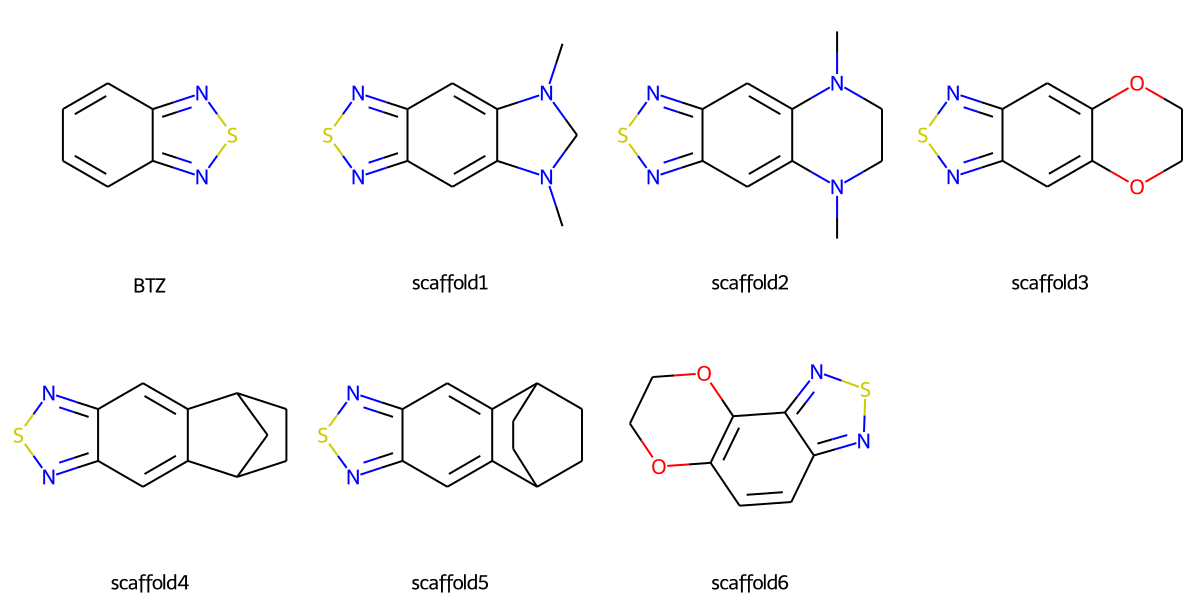

In [132]:
scaff=['c1ccc2nsnc2c1',
 'CN1CN(C)c2cc3nsnc3cc21',
 'CN1CCN(C)c2cc3nsnc3cc21',
 'c1c2c(cc3nsnc13)OCCO2',
 'c1c2c(cc3nsnc13)C1CCC2C1',
 'c1c2c(cc3nsnc13)C1CCC2CC1',
 'C1COc2c(cc(c4nsnc24))O1']

mols=[Chem.MolFromSmiles(smi) for smi in scaff]
col_txt=['BTZ','scaffold1', 'scaffold2', 'scaffold3', 'scaffold4', 'scaffold5', 'scaffold6']
dm.to_image(mols=mols,legends=col_txt,legend_fontsize=20)

In [133]:
for idx,smi in enumerate(scaff):
    col=col_txt[idx]
    df22_rdkit[col]=df22_rdkit["smiles"].apply(lambda x:1*substruct_in_smi(mol_smi_str=x,pat_smi_str=smi))
    

In [134]:
# other_btzs: molecules other than scaffold1-6
df22_rdkit=df22_rdkit.drop(columns="BTZ")
df22_rdkit["other_btzs"]=0

In [135]:
df22_rdkit["other_btzs"][(df22_rdkit["scaffold1"]==0)&(df22_rdkit["scaffold2"]==0)&(df22_rdkit["scaffold3"]==0)&(df22_rdkit["scaffold4"]==0)&(df22_rdkit["scaffold5"]==0)&(df22_rdkit["scaffold6"]==0)]=1

c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [136]:
print(df22_rdkit.shape)
df22_rdkit.head()

(2763, 218)


,smiles,MPP_all(A),MPP_heavy(A),MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,scaffold1,scaffold2,scaffold3,scaffold4,scaffold5,scaffold6,other_btzs
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,0.477902,8.673164,-4.313692,8.673164,0.278641,0.861773,291.424,270.256,291.151767,108,0,0.109421,-0.371076,0.371076,0.109421,1.550000,2.500000,3.300000,1.460045e-15,-0.246537,-2.572833e-17,-2.722027,-1.166959e-16,-2.828997,4.401419e-16,-1.048429,2.676061,1319.710561,32.317473,30.644316,10.460813,17.869915,15.574823,5.805120,3.612095,4.140543,2.417668,2.946116,1.611669,2.125660,-1.40,1.083990e+08,3.329290,5.179478,2.226066,153.172494,14.699729,11.033401,0.000000,0.0,0.0,0.0,0.0,0.0,8.74708,0.0,0.000000,26.845965,57.717337,32.698270,28.785930,34.136361,0.0,13.64699,0.0,6.851892,56.714739,11.605870,0.0,0.0,9.799819,11.374773,0.0,11.728187,60.561909,0.000000,6.851892,34.349381,6.042419,0.000000,11.033401,0.0,35.50,97.580675,0.0,0.0,4.899910,11.728187,0.0,0.0,0.0,0.0,8.747080,28.785930,177.855130,0.330538,-1.645123,0.000000,-5.035603,0.0,-1.044342,0.00000,-31.627267,0.000000,0.571429,20,0,5,0,1,1,1,1,2,6,0,6,7,0,0,0,3,1.81752,86.1890,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,0,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,0.463461,8.626172,-4.129610,8.626172,0.326009,0.864637,292.408,272.248,292.135782,108,0,0.109421,-0.382853,0.382853,0.109421,1.550000,2.500000,3.350000,4.819916e-15,-0.248509,-2.855418e-17,-2.715352,-3.770785e-17,-2.8

In [137]:
# scaff1 and scaff2 both show small Ered; both have planar nitrogen atoms; let's put them in a single group
df22_rdkit["scaffold12"]=0
df22_rdkit["scaffold12"][(df22_rdkit["scaffold1"]==1)|(df22_rdkit["scaffold2"])]=1
df22_rdkit.head()

c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,smiles,MPP_all(A),MPP_heavy(A),MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,scaffold1,scaffold2,scaffold3,scaffold4,scaffold5,scaffold6,other_btzs,scaffold12
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,0.477902,8.673164,-4.313692,8.673164,0.278641,0.861773,291.424,270.256,291.151767,108,0,0.109421,-0.371076,0.371076,0.109421,1.550000,2.500000,3.300000,1.460045e-15,-0.246537,-2.572833e-17,-2.722027,-1.166959e-16,-2.828997,4.401419e-16,-1.048429,2.676061,1319.710561,32.317473,30.644316,10.460813,17.869915,15.574823,5.805120,3.612095,4.140543,2.417668,2.946116,1.611669,2.125660,-1.40,1.083990e+08,3.329290,5.179478,2.226066,153.172494,14.699729,11.033401,0.000000,0.0,0.0,0.0,0.0,0.0,8.74708,0.0,0.000000,26.845965,57.717337,32.698270,28.785930,34.136361,0.0,13.64699,0.0,6.851892,56.714739,11.605870,0.0,0.0,9.799819,11.374773,0.0,11.728187,60.561909,0.000000,6.851892,34.349381,6.042419,0.000000,11.033401,0.0,35.50,97.580675,0.0,0.0,4.899910,11.728187,0.0,0.0,0.0,0.0,8.747080,28.785930,177.855130,0.330538,-1.645123,0.000000,-5.035603,0.0,-1.044342,0.00000,-31.627267,0.000000,0.571429,20,0,5,0,1,1,1,1,2,6,0,6,7,0,0,0,3,1.81752,86.1890,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,0,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,0.463461,8.626172,-4.129610,8.626172,0.326009,0.864637,292.408,272.248,292.135782,108,0,0.109421,-0.382853,0.382853,0.109421,1.550000,2.500000,3.350000,4.819916e-15,-0.248509,-2.855418e-17,-2.715352,-3.77

In [138]:
df22_rdkit.scaffold12.sum()

1599

# Remove duplicate smiles

In [139]:
df22

,Ered_ag,SMILES,MPP_all(Angstrom),MPP_heavy(Angstrom)
0,-2.58,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,0.477902
1,-2.58,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,0.463461
2,-2.61,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.279319,0.873632
3,-2.63,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.039480,0.676225
4,-2.65,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.296932,0.896958
...,...,...,...,...
2758,-2.60,CCCN1CCN(CCOCC)c2cc3nsnc3c(C)c21,1.129065,0.784149
2759,-2.74,CCC(C)OCCN1CN(C)c2cc3nsnc3cc21,1.075593,0.678972
2760,-2.78,CCN(C)c1c2c(cc3nsnc13)N(CC)CN2CC,1.195435,0.737310
2761,-2.72,CCCCOCCN1CN(C)c2cc3nsnc3cc21,0.722666,0.318269


In [140]:
print(f"before: {df22.shape}")
df22["SMILES"]=df22["SMILES"].apply(lambda x:Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df22=df22.drop_duplicates(subset="SMILES")
print(f"after: {df22.shape}")

before: (2763, 4)
after: (2763, 4)


In [141]:
print(f"before: {df22_rdkit.shape}")
df22_rdkit["smiles"]=df22_rdkit["smiles"].apply(lambda x:Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df22_rdkit=df22_rdkit.drop_duplicates(subset="smiles")
print(f"after: {df22_rdkit.shape}")

before: (2763, 219)
after: (2763, 219)


# Remove smiles with HeavyAtomMolWt > 300

In [142]:
print(f"before: df22.shape = {df22.shape}, df22_rdkit={df22_rdkit.shape}]")
from rdkit.Chem.Descriptors import HeavyAtomMolWt
df22_rdkit["HeavyAtomMolWt"]=df22["SMILES"].apply(lambda x:HeavyAtomMolWt(Chem.MolFromSmiles(x)))
df22=df22[df22_rdkit["HeavyAtomMolWt"] <= 300]
df22_rdkit=df22_rdkit[df22_rdkit["HeavyAtomMolWt"] <= 300]
df22_rdkit=df22_rdkit.drop(columns="HeavyAtomMolWt")
print(f"after: df22.shape = {df22.shape}, df22_rdkit={df22_rdkit.shape}]")

before: df22.shape = (2763, 4), df22_rdkit=(2763, 219)]
after: df22.shape = (2733, 4), df22_rdkit=(2733, 218)]


In [143]:
df22.index=np.arange(len(df22))
# df22_rdkit=df22_rdkit.drop(columns="smiles")
df22_rdkit.index=np.arange(len(df22_rdkit))

# Change reference from Li/Li+ to Ag/Ag+

In [144]:
# df22.insert(3,"Ered_ag",df22["DelE_red(V)"].loc[:]-3.85)

In [145]:
df22.head()

,Ered_ag,SMILES,MPP_all(Angstrom),MPP_heavy(Angstrom)
0,-2.58,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,0.908587,0.477902
1,-2.58,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,0.799408,0.463461
2,-2.61,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.279319,0.873632
3,-2.63,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.039480,0.676225
4,-2.65,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.296932,0.896958


In [146]:
df22.Ered_ag.describe()

count    2733.000000
mean       -2.555977
std         0.183044
min        -3.070000
25%        -2.706789
50%        -2.599663
75%        -2.400000
max        -1.980000
Name: Ered_ag, dtype: float64

In [147]:
def plot_one(df,descriptor,filename="figure_one.png"):
    plt.tick_params(reset=True)
    sns.set(font_scale=1.5)
    sns.set_style('white')
    sns.histplot(x=df[descriptor],color="green",kde=True)
    plt.xlabel("$E\'_{Red}$, $V$ vs $Ag/Ag^{+}$ in MeCN")
    # sns.distplot(x=df[descriptor],color="green", bins=50,kde=True)
    # plt.xlim(df[descriptor].min()-round(df[descriptor].min()/100,0),df[descriptor].max()+round(df[descriptor].max()/100,0))
    
    # plt.xticks(np.arange(1,9.5,step=1))
    # plt.xlim(2.5,9.5)
    # plt.ylim(200,20000)
    # plt.yticks(np.arange(100,20000,step=5000))
    # plt.rcParams.update({'font.size':30})
    plt.tight_layout()
    plt.savefig(filename,dpi=300)

In [148]:
import os
# Directory
directory = "al_2700_mpp_scaffol12"
  
# Parent Directory path
parent_dir = "./"
  
# Path
path = os.path.join(parent_dir, directory)
if not os.path.isdir(path):  
    os.mkdir(path)
    print("Directory '% s' created" % directory)

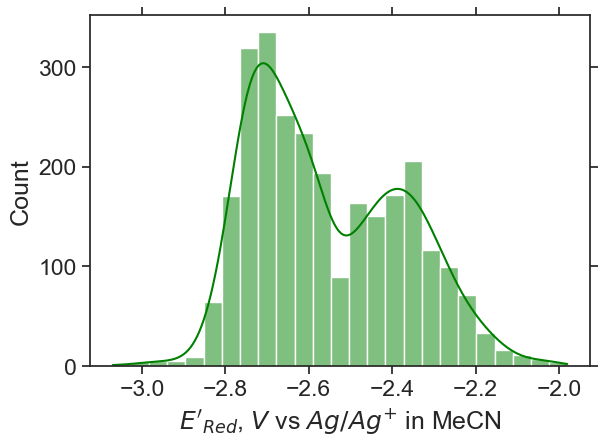

In [149]:
folder_path=directory+"/"
plot_one(df=df22,descriptor="Ered_ag", filename=folder_path+"ERed_1530mols.png")

# Shapiro-Wilk test for normality

In [150]:
from scipy.stats import shapiro

#get stats
data=df22.Ered_ag
stat,p = shapiro(data)

print(f"stat={stat:0.3f} and p={p:0.3f}")
if p > 0.05:
    print("we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian")
else:
    print("we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian")

stat=0.958 and p=0.000
we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian


# Ered is not normally distributed

# Clean descriptors dataframe

In [151]:
df22_rdkit=data_cleaning(df=df22_rdkit)

Removing 0 columns with nan, if any
Before: df.shape=(2733, 218)
After: df.shape=(2733, 218) 

removing 0 duplicate columns, if any
Before: df.shape=(2733, 218)
After: df.shape=(2733, 218) 

removing 90 columns values with a unique value
Before: df.shape=(2733, 218)
After: df.shape=(2733, 128) 

returning a clean df


In [152]:
df22_rdkit.columns

Index(['smiles', 'MPP_all(A)', 'MPP_heavy(A)', 'MaxEStateIndex',
       'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed',
       'MolWt', 'ExactMolWt',
       ...
       'fr_ether', 'fr_methoxy', 'scaffold1', 'scaffold2', 'scaffold3',
       'scaffold4', 'scaffold5', 'scaffold6', 'other_btzs', 'scaffold12'],
      dtype='object', length=128)

# Scale descriptors before the PCA

In [153]:
df22_rdkit=df22_rdkit.drop(columns="smiles")

In [154]:
df22_rdkit_st=do_scaling(xtrain=df22_rdkit)

test data is not provided, returning only scaled train data


In [155]:
df22_rdkit_st.head()

,MPP_all(A),MPP_heavy(A),MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_C_O,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_Ndealkylation1,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ether,fr_methoxy,scaffold1,scaffold2,scaffold3,scaffold4,scaffold5,scaffold6,other_btzs,scaffold12
0,-0.185200,-0.397770,-0.291897,-1.019214,-0.291897,0.631558,0.622108,0.485672,0.485691,0.521786,-0.819440,0.616313,-0.616313,-0.819440,-0.135049,0.082388,0.089724,-1.060333,0.139140,-0.131996,-1.366661,-0.132166,-1.205023,-0.852391,0.756049,0.021250,0.529383,0.655842,0.684387,0.517632,0.644479,0.674184,0.447969,0.466395,0.466395,0.140393,0.140393,-0.076231,-0.087228,0.203734,-0.218378,-0.054499,0.499019,0.812726,0.599796,0.645641,-0.741055,-0.731105,-0.399468,-0.274113,-0.242121,-0.162127,-0.315654,-1.141341,0.278225,1.789425,0.223177,-0.105597,0.252067,6.457796,-0.412198,-1.558374,2.192082,0.215611,-0.783415,-0.274432,0.410014,-0.783415,2.825882,-0.820309,1.064317,-0.859059,0.021833,-0.559969,-0.716968,0.822075,-0.391567,-1.055924,0.670934,-0.087996,-0.356225,0.181254,0.663260,-0.310459,-0.753410,-0.303060,-0.601790,0.851772,0.392487,1.072146,-1.696969,0.528088,0.563989,0.495970,-0.559969,0.464397,-0.260122,0.433024,0.071509,0.5871,-0.559969,0.464397,0.207699,-0.235839,-0.235839,0.071509,-0.883278,0.704491,-0.156086,-0.156086,1.624436,-0.559969,4.432943,0.524223,1.046392,-0.179792,-0.156086,-1.008639,-0.528228,-1.025574,3.578132,-0.233234,-0.174766,-0.153608,-0.147249,-0.63821,0.842136
1,-0.650815,-0.461205,-0.325256,-0.537799,-0.325256,1.094370,0.652289,0.513652,0.513689,0.521786,-0.819440,0.530440,-0.530440,-0.819440,-0.135049,0.082388,0.260240,-1.060333,-0.129212,-0.131996,-1.284321,-0.132166,-1.050303,-0.852391,0.951325,0.084773,0.480315,0.493224,0.489164,0.485608,0.495133,0.482881,0.428333,0.204860,0.204860,0.255997,0.255997,0.077745,0.063419,0.203734,-0.309871,0.377761,0.893733,0.578451,0.501415,0.609770,-0.741055,-0.731105,-0.399468,-0.274113,-0.242121,-0.162127,-0.315654,-1.141341,-0.276783,1.111064,1.652145,0.460350,0.252067,-0.154852,-0.412198,-1.042248,1.666193,0.215611,-0.783415,-0.274432,0.410014,-0.783415,1.646379,0.347310,1.064317,-0.548041,0.021833,-0.559969,-0.155080,0.540030,-0.391567,-1.055924,0.670934,-0.087996,2.657905,-0.064790,0.524546,-0.343458,-0.321925,-0.303060,-0.641291,0.851772,0.372426,1.072146,-1.161873,-1.649827,0.563989,0.495970,-0.559969,0.464397,-0.260122,0.433024,0.071509,0.5871,-0.559969,0.464397,0.207699,-0.235839,-0.235839,0.071509,-0.395050,0.522907,-0.156086,-0.156086,0.628344,-0.559969,2.043351,0.524223,1.046392,-0.179792,-0.156086,0.272909,1.516597,-1.025574,3.578132,-0.233234,-0.174766,-0.153608,-0.147249,-0.63821,0.842136
2,1.395858,1.340540,-0.261046,-0.748128,-0.261046,0.610778,1.465606,0.485672,0.485691,0.521786,-0.212236,0.538626,-0.538626,-0.212236,0.768395,

# PCA

In [156]:
df22_rdkit_st.isna().any().sum()

0

C:\Users\jaina\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


No. of PC           Cumulative variance                                                             
--------------------------------------------------
1                   0.320341                                                                        
2                   0.455411                                                                        
3                   0.544871                                                                        
4                   0.608459                                                                        
5                   0.657095                                                                        
6                   0.702673                                                                        
7                   0.734543                                                                        
8                   0.761821                                                                        
9                   0.787271            

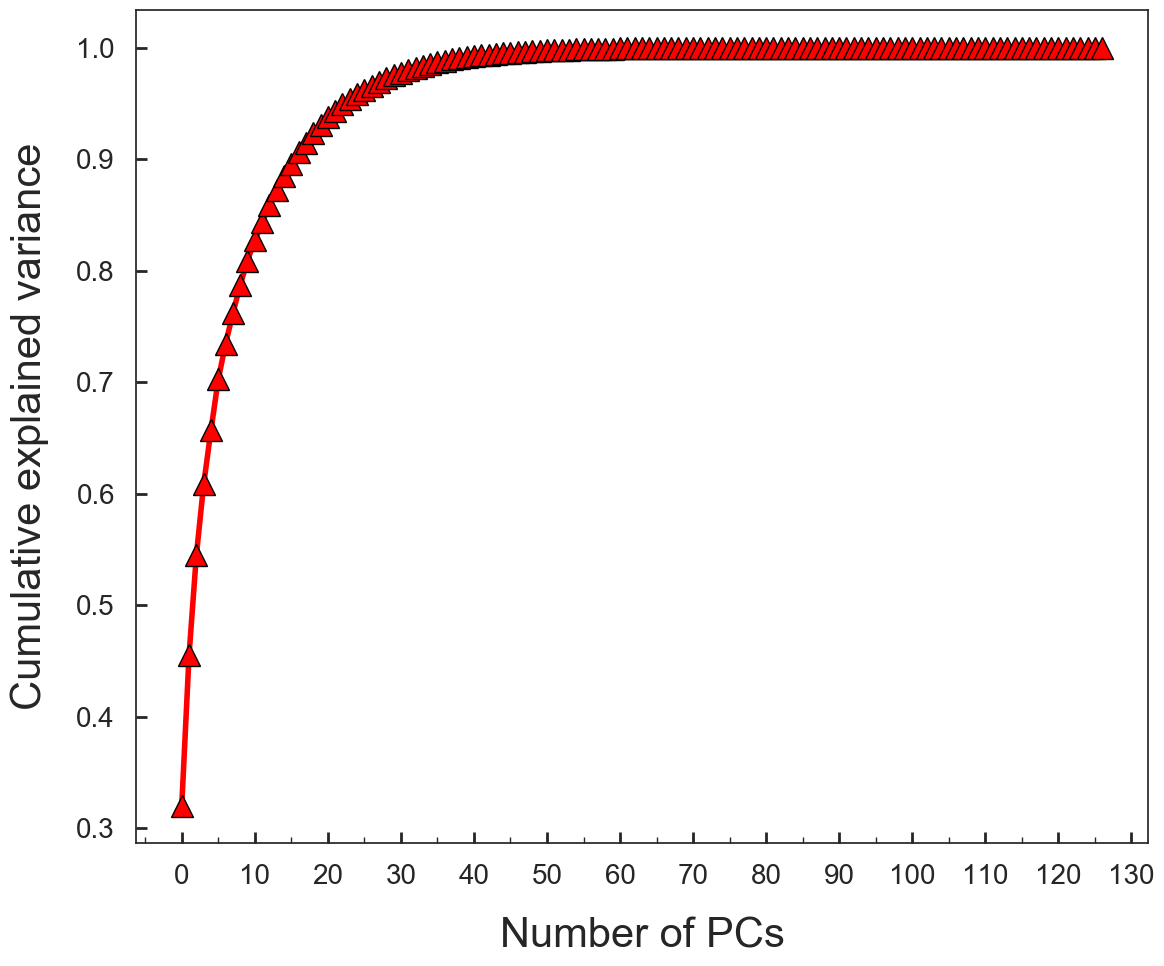

In [157]:
from sklearn.decomposition import PCA # Principle component analysis
import matplotlib.pyplot as plt  
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

X=df22_rdkit_st # scaled data

pca = PCA().fit(X)

#Plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of PCs', fontsize=30,labelpad=20)
ax1.set_ylabel('Cumulative explained variance', fontsize=30,labelpad=20)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis='both', which='major', direction='in', size=8, left='on', bottom='on', width=2, pad=15)
ax1.tick_params(axis='both', which='minor', direction='in', size=4, left='on', bottom='on',width=1, pad=15)
ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)

plt.gcf().set_size_inches((12, 10))
evr = np.cumsum(pca.explained_variance_ratio_)
ax1.plot(evr, marker='^',markersize=16, markeredgecolor='black', 
         linestyle='-',linewidth=4, color='red')   # Plotting
plt.tight_layout()
# plt.savefig("./df_stats_1500/"+"pca_1530.png",dpi=300)
print('{:<20s}{:<80s}'.format('No. of PC','Cumulative variance'))
print(50*'-')
for i,a in enumerate(evr):
    if a<=1:
        print('{:<20d}{:<80f}'.format(i+1,a))

# Use 16 PCs

In [158]:
n_PC = 16  # Set number of principle components
pca = PCA(n_components=n_PC)
Xdata = pca.fit_transform(df22_rdkit_st)  # Transform feature vectors to PCs

# Plot PC1 and PC2 heatmap with Ered_ag

In [159]:
col_txt=["PC"+str(i+1) for i in np.arange(n_PC)]
df_xdata=pd.DataFrame(Xdata,columns=col_txt)
df_xdata.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,-3.713757,-1.179656,-4.363524,-1.074092,-1.112191,2.767295,-0.366039,1.088572,-1.101787,-0.662397,7.237342,1.602313,1.161038,-2.482453,0.285851,-1.952269
1,-2.992753,-0.809957,-4.092704,0.601255,-0.799398,1.264908,0.270010,2.911806,0.341243,-1.034504,2.852750,1.370125,1.517843,-3.319284,-1.911383,0.041057
2,-4.667848,0.216799,-2.680955,-2.825602,-2.742312,2.599633,-3.651323,0.512348,-0.296062,1.334860,1.799037,0.522996,-1.610859,-1.017514,-2.289302,-0.201658
3,-6.570506,-0.519282,-2.484420,-2.247547,-2.491070,1.928956,-3.523834,0.007510,0.920178,1.928812,1.962470,1.305278,-0.708569,-1.507374,-0.548937,0.041220
4,-6.803460,-0.592015,-2.459656,-2.698024,-2.513043,1.966830,-3.725513,0.416613,-0.014191,1.870474,1.808774,0.738513,-1.820070,-1.178722,-1.932747,-0.361650


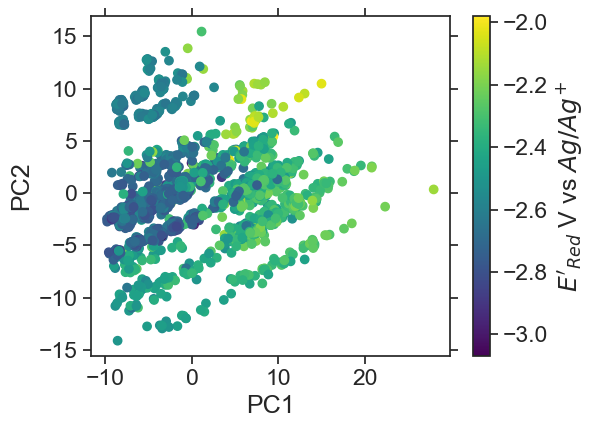

In [160]:
plt.tick_params(reset=True)
plt.scatter(x=df_xdata.PC1,y=df_xdata.PC2,c=df22.Ered_ag,cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.title("E\'red",loc='right')
#set font of all elements to size 15
plt.rc('font', size=24) 
plt.colorbar(label="$E\'_{Red}$ V vs $Ag/Ag^{+}$")
# plt.legend()
plt.tight_layout()

plt.savefig(folder_path+"PC1_PC2_ERed_Ag_1530.png",dpi=300)

# Base model

# GPytorch model

In [161]:
import torch, gpytorch
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split

In [162]:
def gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1,verbose=False):
    
    """
    Gaussian Process Regression implementation with the GPyTorch
    
    Input: gpregression_pytorch(X_train,y_train,num_iter,learning_rate)
    
    Retrun: trained_model, trained_likelihood

    """
    # nfeatures=X_train.shape[1]
    train_x=torch.from_numpy(np.array(X_train))
    train_y=torch.from_numpy(np.array(y_train))
    torch.set_default_dtype(torch.float64)

    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
 
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
        
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # this is for running the notebook in our testing framework
    import os
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else num_iter


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer # for hyperparameter tuning
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose*1*((i+1)%50==0 or i==0):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (i + 1, training_iter, loss.item(),model.covar_module.base_kernel.lengthscale.item(),model.likelihood.noise.item()))
            # print('Iter %d/%d - Loss: %.3f    noise: %.3f' % (i + 1, training_iter, loss.item(),model.likelihood.noise.item()))
        optimizer.step()

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    return model,likelihood

def gprediction_pytorch(model,likelihood,X_test):
    
    """
    Gaussian Process Predictions with gpr_pytorch
    
    Use: 
    model, likelihood = gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1)  
    ypred, ysigma = gprediction__pytorch(model,likelihood,X_test)

    Return: ypred and ysigma numpy arrays
    
    """
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.from_numpy(np.array(X_test))
        torch.set_default_dtype(torch.float64)
        observed_pred = likelihood(model(test_x))
        ypred = observed_pred.mean.numpy()
        ysigma = observed_pred.stddev.numpy()
    return ypred,ysigma

In [163]:
def gpr_one_pytorch(X,y,train_pc=0.8):
    # use X after scalling and pca
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_pc) 

    
    model, likelihood = gpregression_pytorch(X_train,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,X_test)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,X_train)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [164]:
def plot_Ered_gpr(y_true_train,y_pred_train,y_true_test,y_pred_test,y_pred_err_train=None,y_pred_err_test=None,err_bar=False,showfig=True,savefig=False,filename="gpr_pred.png",data=True):
    """
    Return r2,rmse and mae score if data = True
    Show image if showfig=True
    Save image if savefig=True
    """
    
    mae_train = round(MAE(y_true_train,y_pred_train),2)
    r2_train = round(r2_score(y_true_train,y_pred_train),2)
    rmse_train = round(np.sqrt(MSE(y_true_train,y_pred_train)),2)

    mae_test = round(MAE(y_true_test,y_pred_test),2)
    r2_test = round(r2_score(y_true_test,y_pred_test),2)
    rmse_test = round(np.sqrt(MSE(y_true_test,y_pred_test)),2)

    # print(f"(Train: R2 = %0.2f, RMSE = %0.2f, MAE = %0.2f)" %(r2_train,rmse_train,mae_train))    
    # print(f"(Test:  R2 = %0.2f, RMSE = %0.2f, MAE = %0.2f)" %(r2_test,rmse_test,mae_test))    
    #set font of all elements to size 15
     
    if showfig:
        plt.figure(figsize=(6, 6)) 
        plt.tick_params(reset=True)
        # plt.scatter(y_true,y_pred,color=color,label=label)
        if err_bar*(y_pred_err_train is not None):
            plt.errorbar(y_true_train,y_pred_train,yerr=y_pred_err_train,color="red",fmt='o',label="Train")

        if err_bar*(y_pred_err_test is not None):
            plt.errorbar(y_true_test,y_pred_test,yerr=y_pred_err_test,color="blue",fmt='o',label="Test")

        plt.plot([y_true_train.min()-0.2,y_true_train.max()+0.2],[y_true_train.min()-0.2,y_true_train.max()+0.2],color='black')
        
        string=f"$R^2$={r2_train:0.2f}, RMSE = {rmse_train:0.2f}"
        plt.text(y_true_train.min()-0.1,y_true_train.max()-0.03,string,color='red')
        # string=f" (train) = {rmse_train:0.2f}"
        # plt.text(y_true_train.min(),y_true_train.max()-0.23,string)
        
        # string=f"$R^2$ (test) = {r2_test:0.2f}"
        string=f"$R^2$={r2_test:0.2f}, RMSE = {rmse_test:0.2f}"
        plt.text(y_true_train.min()-0.1,y_true_train.max()-0.15,string,color="blue")
        # plt.text(0.75,1.60,string)
        # string=f"RMSE (test)= {rmse_test:0.2f}"
        # plt.text(y_true_train.min(),y_true_train.max()-0.35,string)
        # plt.text(0.75,1.55,string)
        plt.rc('font', size=20)
        plt.xlabel('DFT calculated values (V)')
        plt.ylabel('GPR Predicted values (V)')
        plt.xlim([y_true_train.min()-0.1,y_true_train.max()+0.1])
        plt.ylim([y_true_train.min()-0.1,y_true_train.max()+0.1])
        plt.xticks(np.arange(y_true_train.min()-0.1,y_true_train.max()+0.1,0.4))        
        plt.yticks(np.arange(y_true_train.min()-0.1,y_true_train.max()+0.1,0.4))
        # plt.xticks(np.arange(0.7,2,0.2))
        plt.legend(loc='lower right') #best
        plt.tight_layout()
        # print("Train: min error =", round(y_pred_err_train.min(),2),"max_err", round(y_pred_err_train.max(),2))
        # print("Test: min error =", round(y_pred_err_test.min(),2),"max_err", round(y_pred_err_test.max(),2))
        if savefig:
            plt.savefig(filename,dpi=300,bbox_inches='tight')
        plt.show()


    if data:
        return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

# Learning curves for Number of PCs

In [165]:
def gpr_one_pca_pytorch(X,y,train_pc=0.8,nPC=5,random_state=None):

    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_pc,random_state=random_state) 

    xtrain, xtest = do_scaling(scaler=StandardScaler(),xtrain=X_train, xtest=X_test)
    # PCA
    n_PC = nPC  # Set number of principle components
    pca = PCA(n_components=n_PC)
        
    xtrain = pca.fit_transform(xtrain) 
    xtest=pca.transform(xtest)
    # print(f"xtrain.shape={xtrain.shape},xtest.shape={xtest.shape}")
    model, likelihood = gpregression_pytorch(xtrain,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,xtest)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,xtrain)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [166]:
def helper(X,y,nPC=5,train_pc=0.8,random_state=None):
    y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_pc=train_pc,nPC=nPC,random_state=random_state)
    r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train=plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=False,savefig=False,data=True)
    return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

In [167]:
train_pcs=np.arange(0.1,1,0.1)
num_PCs = [4, 8, 16, 32, df22_rdkit_st.shape[1]]

In [168]:
num_PCs

[4, 8, 16, 32, 127]

In [169]:
train_pcs_avg_train_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_avg_test_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_std_train_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_std_test_score=np.zeros([len(train_pcs),len(num_PCs),3])

# Be patient next block of code will take hours to complete

In [170]:
repeats=10
for jdx,tr_pc in enumerate(train_pcs):
    print("-"*10)
    print(f" tr_pc = {tr_pc} \n")

    avg_train_score = np.zeros([len(num_PCs),3])
    avg_test_score = np.zeros([len(num_PCs),3])

    std_train_score = np.zeros([len(num_PCs),3])
    std_test_score = np.zeros([len(num_PCs),3])

    for idx,PCs in enumerate(num_PCs):
        print("+"*10)
        print(f"--> PCs={PCs}, nPCs={num_PCs} <--")
        # split train and test datasets
        X=df22_rdkit
        y=df22.Ered_ag.to_list()
        
        
        r2_train,rmse_train,mae_train=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)
        r2_test,rmse_test,mae_test=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)

        for j in np.arange(repeats):
            print(f" ---> %repeat <-- ={100*j/repeats}")
            r2_test[j],rmse_test[j],mae_test[j],r2_train[j],rmse_train[j],mae_train[j]=helper(X=X,y=y,nPC=PCs,train_pc=tr_pc)

        avg_test_score[idx] = r2_test.mean(),rmse_test.mean(),mae_test.mean()
        avg_train_score[idx] = r2_train.mean(),rmse_train.mean(),mae_train.mean()
        std_test_score[idx] = r2_test.std(),rmse_test.std(),mae_test.std()
        std_train_score[idx] = r2_train.std(),rmse_train.std(),mae_train.std()

    # store scores for each tr_pc
    train_pcs_avg_train_score[jdx] = avg_train_score
    train_pcs_avg_test_score[jdx] = avg_test_score
    train_pcs_std_train_score[jdx] = std_train_score
    train_pcs_std_test_score[jdx] = std_test_score

----------
 tr_pc = 0.1 

++++++++++
--> PCs=4, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=8, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=16, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=32, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=127, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


----------
 tr_pc = 0.2 

++++++++++
--> PCs=4, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=8, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=16, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=32, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=127, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


----------
 tr_pc = 0.30000000000000004 

++++++++++
--> PCs=4, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=8, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=16, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=32, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=127, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


----------
 tr_pc = 0.4 

++++++++++
--> PCs=4, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=8, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=16, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=32, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=127, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


----------
 tr_pc = 0.5 

++++++++++
--> PCs=4, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=8, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=16, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=32, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=127, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


----------
 tr_pc = 0.6 

++++++++++
--> PCs=4, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=8, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=16, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=32, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=127, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


----------
 tr_pc = 0.7000000000000001 

++++++++++
--> PCs=4, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=8, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=16, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=32, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=127, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


----------
 tr_pc = 0.8 

++++++++++
--> PCs=4, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=8, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=16, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=32, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=127, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


----------
 tr_pc = 0.9 

++++++++++
--> PCs=4, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=8, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=16, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=32, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


++++++++++
--> PCs=127, nPCs=[4, 8, 16, 32, 127] <--
 ---> %repeat <-- =0.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =10.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =20.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =30.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =40.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =50.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =60.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =70.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =80.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


 ---> %repeat <-- =90.0
returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


# Plot Learning curves

In [171]:
train_pcs

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [172]:
y_r2_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_4pc=[train_pcs_std_train_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_4pc=[train_pcs_std_train_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_4pc=[train_pcs_std_train_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_8pc=[train_pcs_std_train_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_8pc=[train_pcs_std_train_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_8pc=[train_pcs_std_train_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_16pc=[train_pcs_std_train_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_16pc=[train_pcs_std_train_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_16pc=[train_pcs_std_train_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_32pc=[train_pcs_std_train_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_32pc=[train_pcs_std_train_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_32pc=[train_pcs_std_train_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_46pc=[train_pcs_std_train_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_46pc=[train_pcs_std_train_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_46pc=[train_pcs_std_train_score[x][4][2] for x in np.arange(len(train_pcs))]


In [173]:
# plt.style.use("default")

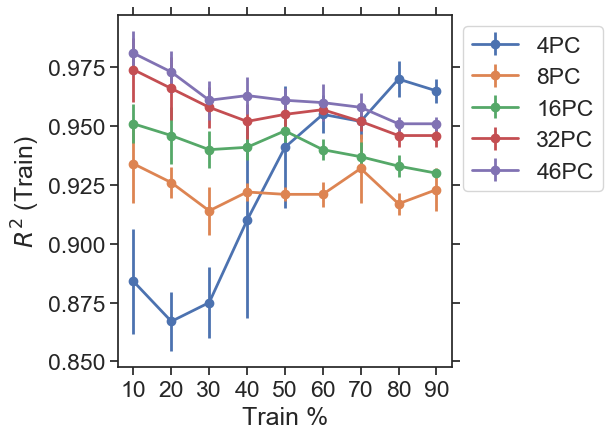

In [174]:
plt.tick_params(reset=True)
# plt.rcParams['ytick.labelsize'] = 25
# plt.rc('font', size=20) 
# plt.figure(figsize=(4,6))
plt.errorbar(x=100*train_pcs,y=y_r2_avg_tr_10_4pc,yerr=y_r2_std_tr_10_4pc,label="4PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_8pc,yerr=y_r2_std_tr_10_8pc,fmt='-o',label="8PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_16pc,yerr=y_r2_std_tr_10_16pc,fmt='-o',label="16PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_32pc,yerr=y_r2_std_tr_10_32pc,fmt='-o',label="32PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_46pc,yerr=y_r2_std_tr_10_46pc,fmt='-o',label="46PC",linewidth=2)
plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("$R^{2}$ (Train)")
plt.xticks(100*train_pcs)
# plt.legend(l)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"r2_train_learning_curve_train_test_pcs.png",dpi=300)

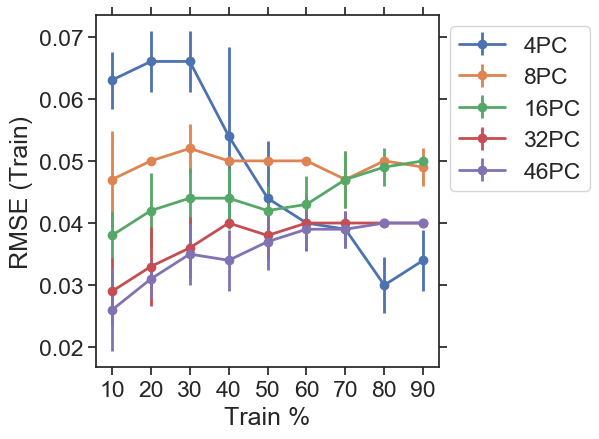

In [175]:
plt.tick_params(reset=True)
plt.errorbar(x=100*train_pcs,y=y_rmse_avg_tr_10_4pc,yerr=y_rmse_std_tr_10_4pc,label="4PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_8pc,yerr=y_rmse_std_tr_10_8pc,fmt='-o',label="8PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_16pc,yerr=y_rmse_std_tr_10_16pc,fmt='-o',label="16PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_32pc,yerr=y_rmse_std_tr_10_32pc,fmt='-o',label="32PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_46pc,yerr=y_rmse_std_tr_10_46pc,fmt='-o',label="46PC",linewidth=2)

plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("RMSE (Train)")
plt.xticks(100*train_pcs)
# plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"rmse_train_learning_curve_train_test_pcs.png",dpi=300)

In [176]:
# save numpy array as npy file
from numpy import asarray
from numpy import save
# define data
# data = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [177]:

# save to npy file
save(folder_path+'train_pcs_avg_test_score.npy', train_pcs_avg_test_score)
save(folder_path+'train_pcs_avg_train_score.npy', train_pcs_avg_train_score)
save(folder_path+'train_pcs_std_test_score.npy', train_pcs_std_test_score)
save(folder_path+'train_pcs_std_train_score.npy', train_pcs_std_train_score)

In [178]:
# # load numpy array from npy file
# from numpy import load
# # load array
# data = load(r'./Data/1500_learning_curve_data/train_pcs_avg_test_score.npy')
# # print the array
# print(data)

In [179]:
y_r2_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_4pc=[train_pcs_std_test_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_4pc=[train_pcs_std_test_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_4pc=[train_pcs_std_test_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_8pc=[train_pcs_std_test_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_8pc=[train_pcs_std_test_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_8pc=[train_pcs_std_test_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_16pc=[train_pcs_std_test_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_16pc=[train_pcs_std_test_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_16pc=[train_pcs_std_test_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_32pc=[train_pcs_std_test_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_32pc=[train_pcs_std_test_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_32pc=[train_pcs_std_test_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_46pc=[train_pcs_std_test_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_46pc=[train_pcs_std_test_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_46pc=[train_pcs_std_test_score[x][4][2] for x in np.arange(len(train_pcs))]


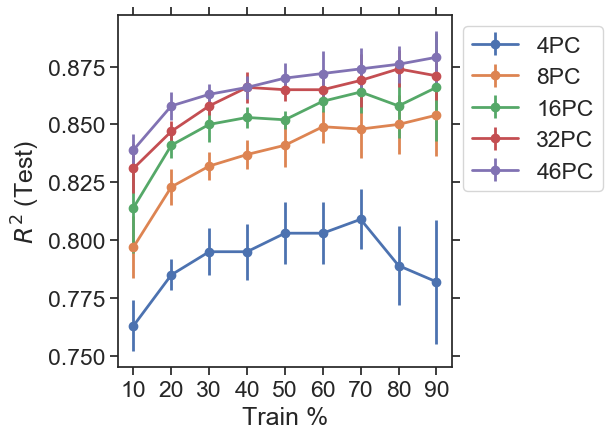

In [180]:
plt.tick_params(reset=True)
plt.errorbar(x=100*train_pcs,y=y_r2_avg_ts_10_4pc,yerr=y_r2_std_ts_10_4pc,label="4PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_8pc,yerr=y_r2_std_ts_10_8pc,fmt='-o',label="8PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_16pc,yerr=y_r2_std_ts_10_16pc,fmt='-o',label="16PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_32pc,yerr=y_r2_std_ts_10_32pc,fmt='-o',label="32PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_46pc,yerr=y_r2_std_ts_10_46pc,fmt='-o',label="46PC",linewidth=2)
plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("$R^{2}$ (Test)")
plt.xticks(100*train_pcs)
# plt.legend(l)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"r2_test_learning_curve_train_test_pcs.png",dpi=300)

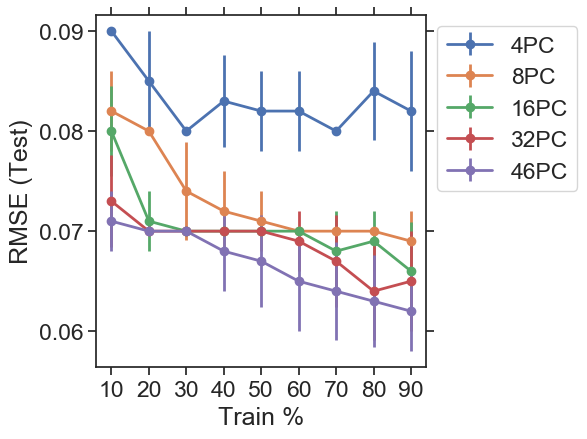

In [181]:
plt.tick_params(reset=True)
# plt.tick_params(axis='both',which='minor')
plt.errorbar(x=100*train_pcs,y=y_rmse_avg_ts_10_4pc,yerr=y_rmse_std_ts_10_4pc,label="4PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_8pc,yerr=y_rmse_std_ts_10_8pc,fmt='-o',label="8PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_16pc,yerr=y_rmse_std_ts_10_16pc,fmt='-o',label="16PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_32pc,yerr=y_rmse_std_ts_10_32pc,fmt='-o',label="32PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_46pc,yerr=y_rmse_std_ts_10_46pc,fmt='-o',label="46PC",linewidth=2)

plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("RMSE (Test)")
plt.xticks(100*train_pcs)
# plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"rmse_test_learning_curve_train_test_pcs.png",dpi=300)

In [182]:
def plot_R2_learning_curve_num_PCs(num_PCs,avg_test_score,avg_train_score,std_test_score,std_train_score,filename="learning_r2.png"):
    plt.tick_params(reset=True)
    plt.plot(num_PCs,avg_train_score[:,0],"-o",label="train",color="blue")
    plt.plot(num_PCs,avg_test_score[:,0],"-o",label="test",color="red")

    plt.scatter(num_PCs,avg_train_score[:,0],color="blue")
    plt.scatter(num_PCs,avg_test_score[:,0],color="red")

    plt.errorbar(num_PCs,avg_train_score[:,0],yerr=std_train_score[:,0],color="blue")
    plt.errorbar(num_PCs,avg_test_score[:,0],yerr=std_test_score[:,0],color="red")

    plt.xlabel("Number of PCs")
    plt.ylabel("R$^2$")
    plt.legend()
    plt.xticks(num_PCs)
    plt.tight_layout()
    plt.savefig(filename,dpi=300)

In [183]:
train_pcs_avg_test_score[-2]

array([[0.789, 0.084, 0.061],
       [0.85 , 0.07 , 0.05 ],
       [0.858, 0.069, 0.05 ],
       [0.874, 0.064, 0.048],
       [0.876, 0.063, 0.046]])

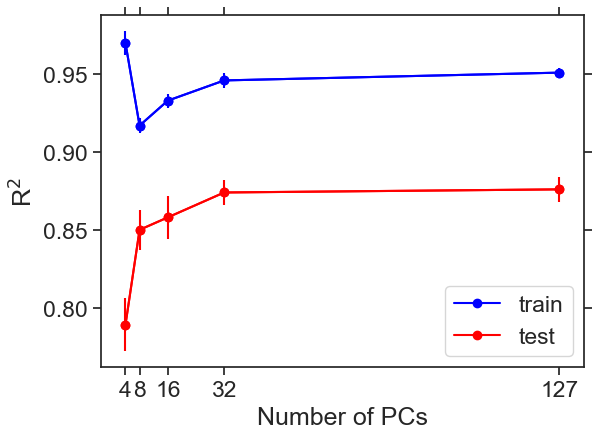

In [184]:
train_pc=-2
plot_R2_learning_curve_num_PCs(num_PCs=num_PCs,avg_test_score=train_pcs_avg_test_score[train_pc],avg_train_score=train_pcs_avg_train_score[train_pc],std_test_score=train_pcs_std_test_score[train_pc],std_train_score=train_pcs_std_train_score[train_pc],filename=folder_path+"R2_learning_curve_test_split_80pc_training.png")

In [185]:
def plot_RMSE_learning_curve_num_PCs(num_PCs,avg_test_score,avg_train_score,std_test_score,std_train_score,filename="learning.png"):
    plt.tick_params(reset=True)
    plt.plot(num_PCs,avg_train_score[:,1],"-o",label="train",color="blue")
    plt.plot(num_PCs,avg_test_score[:,1],"-o",label="test",color="red")

    plt.scatter(num_PCs,avg_train_score[:,1],color="blue")
    plt.scatter(num_PCs,avg_test_score[:,1],color="red")

    plt.errorbar(num_PCs,avg_train_score[:,1],yerr=std_train_score[:,1],color="blue")
    plt.errorbar(num_PCs,avg_test_score[:,1],yerr=std_test_score[:,1],color="red")

    plt.xlabel("Number of PCs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.xticks(num_PCs)
    plt.tight_layout()
    plt.savefig(filename,dpi=300)

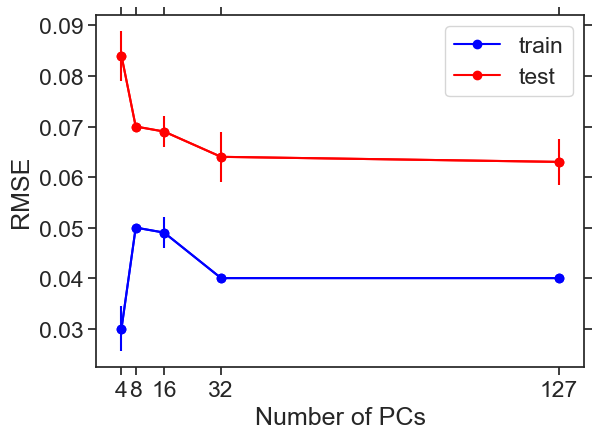

In [186]:
train_pc=-2
plot_RMSE_learning_curve_num_PCs(num_PCs=num_PCs,avg_test_score=train_pcs_avg_test_score[train_pc],avg_train_score=train_pcs_avg_train_score[train_pc],std_test_score=train_pcs_std_test_score[train_pc],std_train_score=train_pcs_std_train_score[train_pc],filename=folder_path+"RMSE_learning_curve_test_split_80pc_training.png")

# The GPR model's RMSE/R2 doesn't imporve much with 32 and 46 (all) PCs (features) compared to the 16 PC case. Hence, it is reasonable to use 16 PCs to achieve both accuracy and efficiency 

In [187]:
# Use 16 PCs and 80-20% train-test split 
X=df_xdata  # df_xdata has 16 PCs
y=df22.Ered_ag
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pytorch(X=X,y=y,train_pc=0.8)

c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


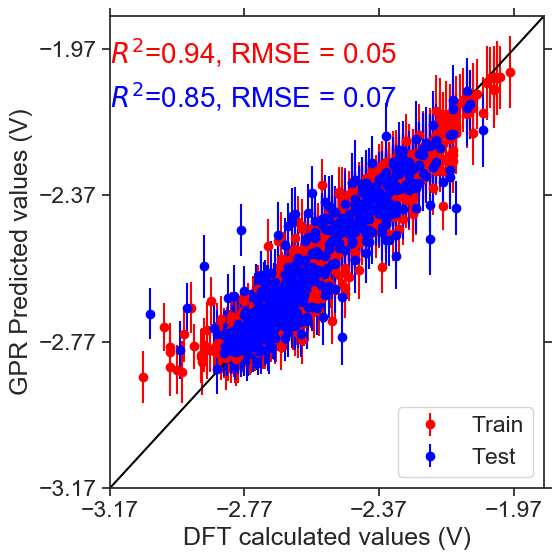

In [188]:
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,data=False,filename=folder_path+"base_model_16PCs_8020_1530mols.png")

# Active Learning to find the molecule with lowest E'Red (V)

In [189]:
def expectedimprovement_pytorch(xdata,gp_model,gp_likelihood,ybest,itag,epsilon):
    from scipy.stats import norm
    ye_pred, esigma = gprediction_pytorch(model=gp_model,likelihood=gp_likelihood,X_test=xdata)
    expI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=itag*(ye_pred[ii]-ybest)/float(esigma[ii])
            expI[ii]=itag*(ye_pred[ii]-ybest-epsilon)*norm.cdf(zzval)+esigma[ii]*norm.pdf(zzval)
        else:
            expI[ii]=0.0
    return expI

def probabilityOfImprovement_pytorch(xdata,gp_model,gp_likelihood,ybest,epsilon):  
    "ybest: GPR-predicted best output property of the TRAINING set"
    from scipy.stats import norm
    ye_pred, esigma = gprediction_pytorch(model=gp_model,likelihood=gp_likelihood,X_test=xdata)
    poI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=(ye_pred[ii]-ybest-epsilon)/float(esigma[ii])
            poI[ii]=norm.cdf(zzval)
        else:
            poI[ii]=0.0
    return poI

# Acquisition functions
def upperConfidenceBound_pytorch(xdata,gp_model,gp_likelihood,epsilon):
    """
        xdata: input feature vectors or PCs of the REMAINING set
        gpnetwork: GPR model
        epsilon: control exploration/exploitation. Higher epsilon means more exploration
    """
    from scipy.stats import norm
    ye_pred, esigma = gprediction_pytorch(model=gp_model,likelihood=gp_likelihood,X_test=xdata)
    ucb = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            ucb[ii]=(ye_pred[ii]+epsilon*esigma[ii])
        else:
            ucb[ii]=0.0
    return ucb

In [191]:
# X=df_xdata  # df_xdata has 16 PCs
Xdata=Xdata
Xsmiles = df22.SMILES
# dfEox=df22.Ered_ag


In [192]:
from tqdm.auto import tqdm

In [193]:
def BayesOpt(Xdata,Ydata,Xinfo,ndata,nPC,eps,af,Niteration,filename):
    ntrain = 10 # Number of initial training data points
    nremain = ndata - ntrain
    dataset = np.random.permutation(ndata)
    a1data = np.empty(ntrain, dtype=int)
    a2data = np.empty(nremain, dtype=int)
    a1data[:] = dataset[0:ntrain]
    a2data[:] = dataset[ntrain:ndata]

    Xtrain = np.ndarray(shape=(ntrain, nPC), dtype=float)
    Xtraininfo = np.chararray(ntrain, itemsize=100)
    Ytrain = np.empty(ntrain, dtype=float)
    Xtrain[0:ntrain, :] = Xdata[a1data, :]
    Xtraininfo[0:ntrain] = Xinfo[a1data]
    Ytrain[0:ntrain] = Ydata[a1data]
    
    yoptLoc = np.argmax(Ytrain)
    yopttval = Ytrain[yoptLoc]

    xoptval = Xtraininfo[yoptLoc]
    yoptstep=0
    yopinit = yopttval
    xoptint = xoptval

    Xremain = np.ndarray(shape=(nremain, nPC), dtype=float)
    Xremaininfo = np.chararray(nremain, itemsize=100)
    Yremain = np.empty(nremain, dtype=float)
    Xremain[0:nremain, :] = Xdata[a2data, :]
    Xremaininfo[0:nremain] = Xinfo[a2data]
    Yremain[0:nremain] = Ydata[a2data]
    
    
    
    pfile = open(filename,'a+')
    pfile.write("batch,Iteration,SMILES,Ered \n")

    for i in range(ntrain):

        pfile.write(f'initial,{i},{Xtraininfo[i].decode()},{-Ytrain[i]:0.2f} \n')

    # print("Total number of inital training points: ", ntrain)
    print(f"Initial best SMILES is {xoptval.decode()} with Ered = {-yopttval:0.2f} V \n")
    
    for ii in tqdm(range(0, Niteration),desc='Progress'):
        model, likelihood = gpregression_pytorch(X_train=Xtrain,y_train=Ytrain,num_iter=350,learning_rate=0.05,verbose=False)
        yt_pred, tsigma = gprediction_pytorch(model,likelihood,X_test=Xtrain)
        
        ybestloc = np.argmax(Ytrain) # The current best y value
         
        ybest = yt_pred[ybestloc]
        ytrue = Ytrain[ybestloc]
                
        if yopttval < ytrue:
            yopttval = ytrue
            xoptval = Xtraininfo[ybestloc]
            
        if af=='EI':

            afValues = expectedimprovement_pytorch(xdata=Xremain, gp_model=model,gp_likelihood=likelihood, ybest=ybest, itag=1, epsilon=eps)
        elif af=='POI':

            afValues = probabilityOfImprovement_pytorch(xdata=Xremain, gp_model=model,gp_likelihood=likelihood, ybest=ybest, epsilon=eps)
        elif af=='UCB':

            afValues = upperConfidenceBound_pytorch(xdata=Xremain, gp_model=model,gp_likelihood=likelihood, psilon=eps)

        # afMax = np.max(afValues)
        afmaxloc = np.argmax(afValues)
        
        xnew = np.append(Xtrain, Xremain[afmaxloc]).reshape(-1, nPC)
        xnewinfo = np.append(Xtraininfo, Xremaininfo[afmaxloc])
        ynew = np.append(Ytrain, Yremain[afmaxloc])
        xrnew = np.delete(Xremain, afmaxloc, 0)
        xrnewinfo = np.delete(Xremaininfo, afmaxloc)
        yrnew = np.delete(Yremain, afmaxloc)
        if ii==0:
            Xexplored=Xremaininfo[afmaxloc]
            Yexplored=Yremain[afmaxloc]
        else:
            Xexploredtemp=np.append(Xexplored, Xremaininfo[afmaxloc])
            Yexploredtemp=np.append(Yexplored, Yremain[afmaxloc])
            del Xexplored,Yexplored
            Xexplored=Xexploredtemp
            Yexplored=Yexploredtemp
        del Xtrain, Ytrain, Xremaininfo, model, likelihood
        # del Xtrain, Ytrain, Xremaininfo
        Xtrain = xnew
        Xtraininfo = xnewinfo
        Ytrain = ynew
        Xremain = xrnew
        Xremaininfo = xrnewinfo
        Yremain = yrnew
        del xnew, xnewinfo, ynew, xrnew, xrnewinfo, yrnew
    
    # What if the best candidate is found in the last step? (this was not present in the Hieu's code)
    # Look for the best candidate in the final YTrain
    
    ybestloc = np.argmax(Ytrain) # The current best y value
    ytrue = Ytrain[ybestloc]

    print(f"yt_true_best = {ytrue:0.2f}")
            
    if yopttval < ytrue:
        yopttval = ytrue
        xoptval = Xtraininfo[ybestloc]
    ###

    if not yopinit==yopttval:
        yoptstep = np.argmax(Yexplored) + 1       
    else:
        yoptstep=0
    dataorder = np.argsort(Yexplored)
    Yexploredtemp=Yexplored[dataorder]
    Xexploredtemp = Xexplored[dataorder]
    

    for i,sml in enumerate(Xexplored):   
        pfile.write(f'sample,{i+1},{sml.decode()},{-Yexplored[i]:0.2f} \n')

    print(f"Global minima in the data is {-Ydata.max():0.2f}")
    print(f"The best SMILES is {xoptval.decode()} with Ered = {-yopttval:0.2f} V, which was found in iteration = {yoptstep} \n")
    pfile.close()
    return xoptint,yopinit,xoptval,yopttval, yoptstep



In [194]:
Ydata = df22.Ered_ag.values 
Ydata = -Ydata  # minimize

print('*** Finding SMILES with minimum $E_{Red}$ ***')
ndata = len(Ydata)
print("Original shape of X and Y :",np.shape(Xdata),np.shape(Ydata))
epsilon=0.01
acquiFunc='EI'  # POI, UCB
Nruns=10 # for statistics
Niteration = 75   # number of iteration in a given Bayesian  Optimization
Xinitguess = np.chararray(Nruns,itemsize=100)
Yinitguess = np.empty(Nruns,dtype=float)
Xoptimal = np.chararray(Nruns,itemsize=100)
Yoptimal = np.empty(Nruns,dtype=float)
Yopt_step = np.empty(Nruns,dtype=float)
# res=[]
for ii in range(0,Nruns):
    print('Run ',ii)
    Xinitguess[ii], Yinitguess[ii], Xoptimal[ii], Yoptimal[ii], Yopt_step[ii] = BayesOpt(Xdata, Ydata, Xsmiles, ndata, n_PC,epsilon,acquiFunc,Niteration,filename=f"{folder_path}BayesOptRunProgress_NR_{ii}.csv")




*** Finding SMILES with minimum $E_{Red}$ ***
Original shape of X and Y : (2733, 16) (2733,)
Run  0
Initial best SMILES is CCCCN1CN(CCC)c2c1cc1nsnc1c2C with Ered = -2.85 V 



Progress:   0%|          | 0/75 [00:00<?, ?it/s]

c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 9 

Run  1
Initial best SMILES is CCC(C)OC1N(C)c2c(cc3nsnc3c2C)N1C(C)C with Ered = -2.78 V 



Progress:   0%|          | 0/75 [00:00<?, ?it/s]

yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 38 

Run  2
Initial best SMILES is CCC(C)N1c2cc3nsnc3cc2N(C)C1OCC(C)C with Ered = -2.75 V 



Progress:   0%|          | 0/75 [00:00<?, ?it/s]

yt_true_best = 2.99
Global minima in the data is -3.07
The best SMILES is COCCOC1N(C)c2cc3nsnc3cc2N1C with Ered = -2.99 V, which was found in iteration = 75 

Run  3
Initial best SMILES is CCN1CN(CC(C)C)c2cc3nsnc3c(N(C)C)c21 with Ered = -2.79 V 



Progress:   0%|          | 0/75 [00:00<?, ?it/s]

yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 75 

Run  4
Initial best SMILES is CCc1c2c(c(C)c3nsnc13)N(CC)CN2CC with Ered = -2.78 V 



Progress:   0%|          | 0/75 [00:00<?, ?it/s]

yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 10 

Run  5
Initial best SMILES is CCc1c2c(cc3nsnc13)N(C(C)CC)CN2C with Ered = -2.85 V 



Progress:   0%|          | 0/75 [00:00<?, ?it/s]

yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 37 

Run  6
Initial best SMILES is CCOC1N(C)c2cc3nsnc3cc2N1C with Ered = -2.88 V 



Progress:   0%|          | 0/75 [00:00<?, ?it/s]

yt_true_best = 2.99
Global minima in the data is -3.07
The best SMILES is COCCOC1N(C)c2cc3nsnc3cc2N1C with Ered = -2.99 V, which was found in iteration = 3 

Run  7
Initial best SMILES is CCCN1CN(CCC)c2c1cc1nsnc1c2C with Ered = -2.80 V 



Progress:   0%|          | 0/75 [00:00<?, ?it/s]

yt_true_best = 2.96
Global minima in the data is -3.07
The best SMILES is CC(C)N1CN(C(C)C)c2cc3nsnc3cc21 with Ered = -2.96 V, which was found in iteration = 8 

Run  8
Initial best SMILES is CCNc1c2c(cc3nsnc13)N(CC)CN2CC with Ered = -2.99 V 



Progress:   0%|          | 0/75 [00:00<?, ?it/s]

yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 70 

Run  9
Initial best SMILES is CCCN1CN(CC)c2cc3nsnc3c(N(C)C(C)C)c21 with Ered = -2.81 V 



Progress:   0%|          | 0/75 [00:00<?, ?it/s]

yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 32 



In [195]:
def plot_bo_progress(df,filename="BO_run.png"):
    plt.figure()
    plt.tick_params(reset=True)
    
    plt.plot([0,86],[-2.14,-2.14],linestyle=":",color="black",linewidth=2)
    plt.plot([0,86],[-3.07,-3.07],linestyle="--",color="red",linewidth=2)

    plt.plot(df["Iteration"][df["batch"]=="initial"],df["Ered"][df["batch"]=="initial"],'-o',label="Initial",color="blue",linewidth=2)
    plt.fill_between(np.arange(1,11),df["Ered"][df["batch"]=="initial"], -3.07, color='blue', alpha=.1)
    
    plt.plot(df["Iteration"][df["batch"]=="sample"]+10,df["Ered"][df["batch"]=="sample"],'-o',label="Sample",color="green",linewidth=2)
    plt.fill_between(np.arange(11,len(df)+1),df["Ered"][df["batch"]=="sample"], -3.07, color='green', alpha=.1)

    plt.rc('font', size=20) 
    plt.xlabel("Iteration")
    plt.ylabel("$E'_{Red}$ (V)")
    plt.legend(loc='upper right')

    plt.xticks(np.arange(1,len(df)+1,10),labels=["0","1","10","20","30","40","50","60","70"], rotation=0)
    plt.tight_layout()
    plt.savefig(filename,dpi=300)
    plt.show()
    

Nrun = 0


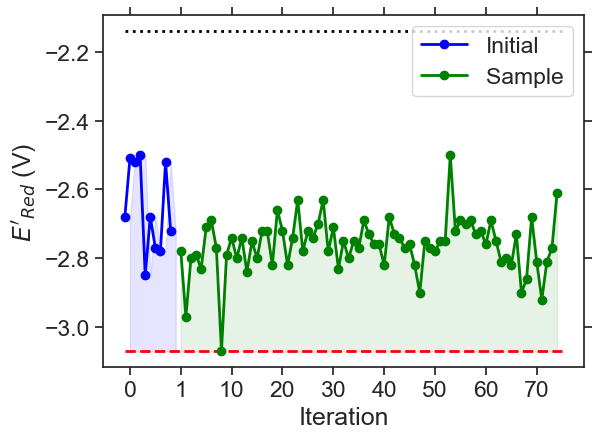

Nrun = 1


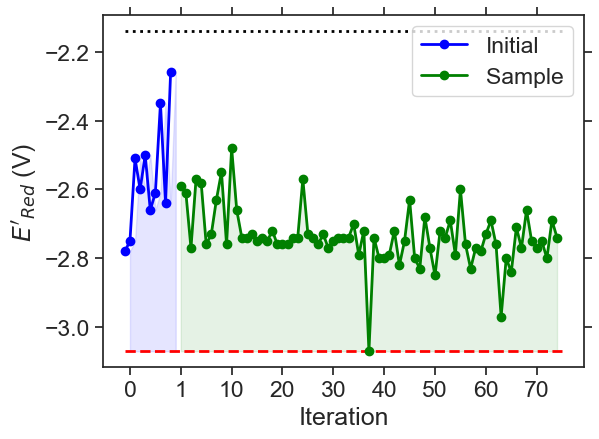

Nrun = 2


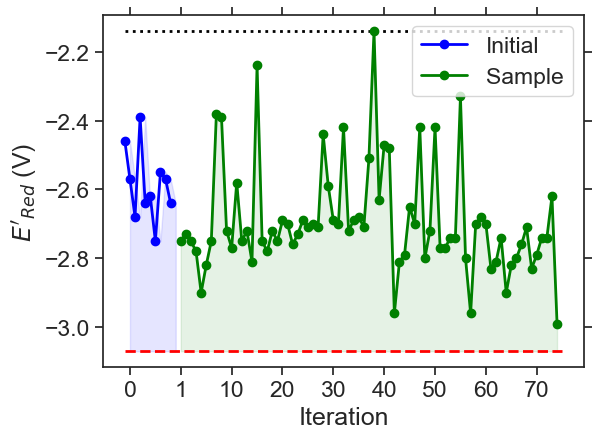

Nrun = 3


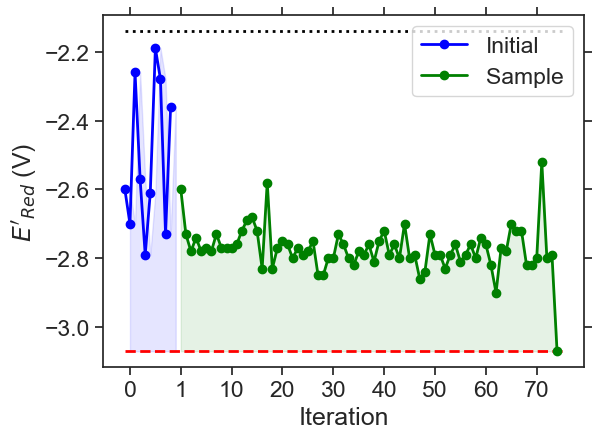

Nrun = 4


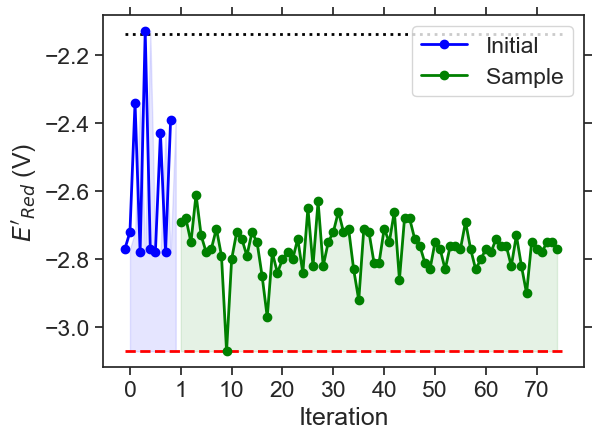

Nrun = 5


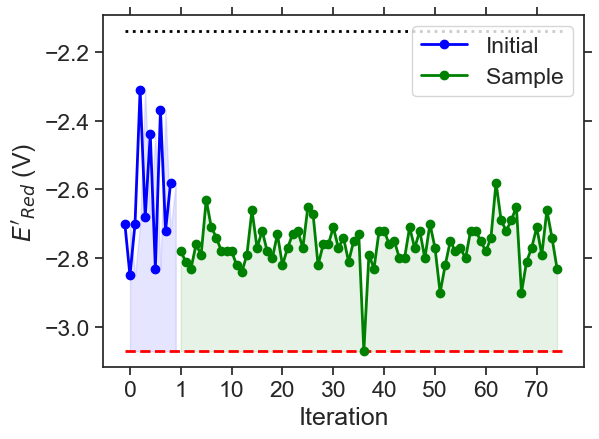

Nrun = 6


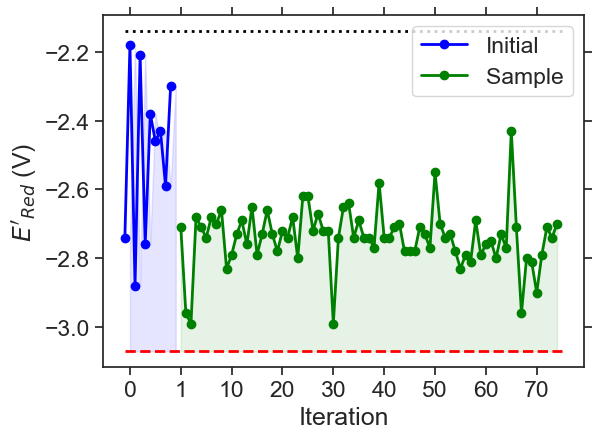

Nrun = 7


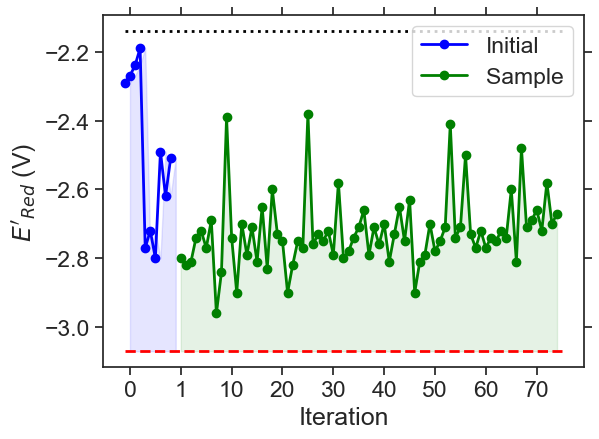

Nrun = 8


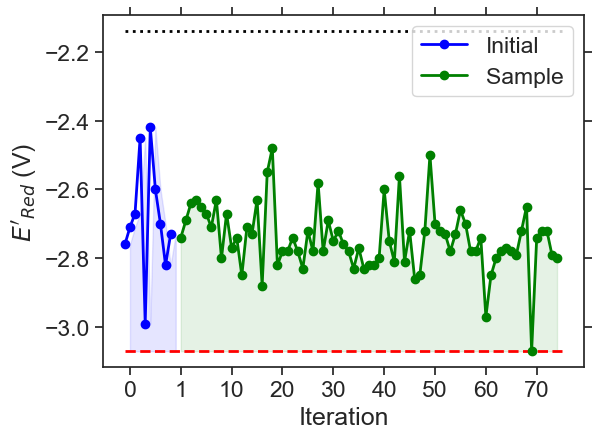

Nrun = 9


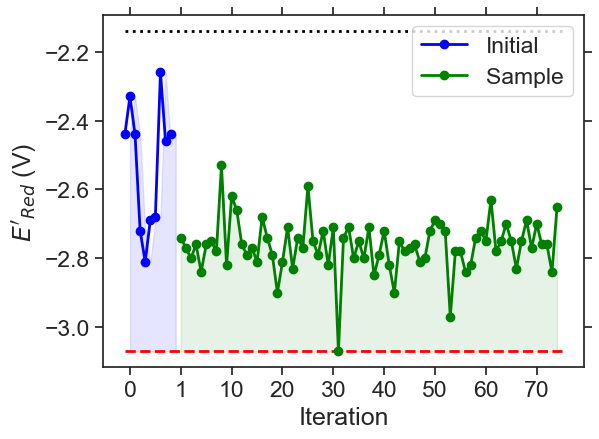

In [196]:
for jj in np.arange(Nruns):
    print(f"Nrun = {jj}")
    
    # file=f"al_1500_mpp/BayesOptRunProgress_NR_{jj}"
    file=f"{folder_path}BayesOptRunProgress_NR_{jj}"
    # print(file+".csv")
    df_bo=pd.read_csv(file+".csv")
    # print(df_bo.columns)
    # df_bo.head()
    # break
    df_bo.columns=['batch','Iteration','SMILES','Ered']
    plot_bo_progress(df=df_bo,filename=file+".png")